# Project 2
## Lawrence Liu Jackie McGinley

# Background
#### A large company named Canterra, employs, at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons:
- The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
- A sizable department has to be maintained, for the purposes of recruiting new talent
- More often than not, the new employees have to be trained for the job and/or given time to acclimatize themselves to the company
#### The management hypothesizes that higher job satisfaction and a higher number of total working years will reduce employee attrition. Additionally, the marketing management was interested to know if demographic variables such as gender, education and age affect employee attrition. Hence, the management has contracted you as a consultant to understand whether these two factors they should focus on, in order to curb attrition. In other words, they want to know if changes in their internal and external recruitment strategies would help retain employees.



In [17]:
### Step 0: Setup ----
# Load any libraries used for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# -------------------------------------------------------------------
# Step 1: Pre-processing
# -------------------------------------------------------------------

print("Do we have missing values? Look at 'Non-Null Count'")
df = pd.read_excel('Employee_Data_Project.xlsx')
df.shape
print(df.info())


Do we have missing values? Look at 'Non-Null Count'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EmployeeID               4410 non-null   int64  
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   MaritalStatus            4410 non-null   object 
 9   Income                   4410 non-null   int64  
 10  NumCompaniesWorked       4391 non-null   float64
 11  StandardHours            4410 non-null   int64  
 12  TotalWorkingYears        4401 non-null   float64
 13  TrainingTimesLastYear    4

#### There are missing values in the NumCompaniesWorked , TotalWorkingYears , EnvironmentSatisfaction , JobSatisfaction Columns

In [3]:
# -------------------------------------------------------------------
# Step 1: Pre-processing (check rows with nulls and visualize those rows)
# -------------------------------------------------------------------
# first step is to get the index of where the nulls are and take a look at only those rows
null_rows = df[df.isnull().any(axis=1)].index
# use the index from null rows to view those rows
df.loc[null_rows]
## confirmed that there are truly NaNs (73 total rows have NaNs)

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,Gender,JobLevel,MaritalStatus,Income,NumCompaniesWorked,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction
11,36,No,Travel_Rarely,28,1,12,Male,1,Married,33770,0.0,8,16.0,2,15,11,NaN,4.0
23,42,No,Travel_Rarely,4,4,24,Male,1,Married,89260,1.0,8,NaN,4,20,6,2.0,3.0
40,36,No,Travel_Frequently,8,3,41,Female,3,Married,69620,4.0,8,4.0,2,1,0,3.0,NaN
111,31,No,Travel_Rarely,1,3,112,Male,4,Single,28670,0.0,8,3.0,5,2,2,NaN,2.0
115,27,No,Travel_Rarely,2,3,116,Male,1,Divorced,23670,NaN,8,5.0,2,5,4,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,36,No,Travel_Rarely,2,3,4227,Male,2,Married,43200,NaN,8,5.0,2,1,0,2.0,4.0
4332,31,No,Travel_Rarely,2,5,4333,Male,2,Married,27280,8.0,8,7.0,3,4,2,NaN,4.0
4345,43,No,Non-Travel,6,2,4346,Male,1,Divorced,20280,4.0,8,7.0,2,5,2,4.0,NaN
4395,40,No,Travel_Rarely,2,3,4396,Male,1,Divorced,27180,NaN,8,9.0,4,9,7,1.0,4.0


- 1.65% of the data is missing, to will do train test split then impute the missing values. 

In [4]:
medians = {'NumCompaniesWorked': df['NumCompaniesWorked'].median(), 'TotalWorkingYears': df['TotalWorkingYears'].median(),
    'EnvironmentSatisfaction': df['EnvironmentSatisfaction'].median(), 'JobSatisfaction': df['JobSatisfaction'].median()}
df = df.fillna(medians)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EmployeeID               4410 non-null   int64  
 6   Gender                   4410 non-null   object 
 7   JobLevel                 4410 non-null   int64  
 8   MaritalStatus            4410 non-null   object 
 9   Income                   4410 non-null   int64  
 10  NumCompaniesWorked       4410 non-null   float64
 11  StandardHours            4410 non-null   int64  
 12  TotalWorkingYears        4410 non-null   float64
 13  TrainingTimesLastYear    4410 non-null   int64  
 14  YearsAtCompany          

#### replaced the null values in NumCompaniesWorked , TotalWorkingYears , EnvironmentSatisfaction , JobSatisfaction Columns with the median as these were numerical data types

---

#### encode attrition 


In [5]:
    
df['Attrition'] = (df['Attrition'] == "Yes").astype(int)


In [6]:
# -------------------------------------------------------------------
# Step 2: Train Test Split
# -------------------------------------------------------------------
X = df.drop(['Attrition','EmployeeID', 'StandardHours'], axis =1)
y = df['Attrition']

X_train , X_test, y_train, y_test = train_test_split(
    X, y, test_size  = 0.3, random_state = 42 , stratify= y
)

X_train.info



<bound method DataFrame.info of       Age     BusinessTravel  DistanceFromHome  Education  Gender  JobLevel  \
2685   33  Travel_Frequently                10          2    Male         2   
3631   39      Travel_Rarely                26          1    Male         2   
1365   45      Travel_Rarely                 1          4    Male         1   
3623   30      Travel_Rarely                 9          1    Male         4   
4390   32      Travel_Rarely                13          4  Female         3   
...   ...                ...               ...        ...     ...       ...   
3369   36      Travel_Rarely                 9          3  Female         2   
3858   49      Travel_Rarely                 4          2    Male         2   
743    37      Travel_Rarely                20          5    Male         2   
808    33      Travel_Rarely                 7          2    Male         2   
1125   36         Non-Travel                 1          3    Male         2   

     MaritalStatus 

- categorical columns:  BusinessTravel , Gender, MaritalStatus
- Numerical Columns: Age, DistanceFromHome , Education , Gender , JobLevel , Income , NumCompaniesWorked , TotalWorkingYears , TrainingTimesLastYear , YearsAtCompany , YearsWithCurrManager , EnvironmentSatisfaction, JobSatisfaction

In [7]:
categorical_columns = ['BusinessTravel', 'Gender', 'MaritalStatus']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns = categorical_columns, drop_first= True, dtype = int )

#### regarding the newly enconded columns 
- When Gender_Male = 1 , then Male. Gender_Male = 0, then Female 
- When MaritalStatus_Married = 1 , then Married 
- When MaritalStatus_Single = 1 , then Single 
- When both MaritalStatus_Married and MaritalStatus_Single are 0, then Divorced 
- When BusinessTravel_Travel_Frequently = 1, then Travel Frequently
- When BusinessTravel_Travel_Rarely = 1, then Travel Rarely 
- When both BusinessTravel_Travel_Frequently and BusinessTravel_Travel_Rarely are 0, then Non Travel

---

#### now that the categorical variables are encoded. The numerical columns will be defined (possbly min-max scaling)

In [8]:
numerical_columns = ['Age', 'DistanceFromHome' , 'Education' , 'Gender', 'JobLevel' , 'Income' , 
'NumCompaniesWorked' , 'TotalWorkingYears' , 'TrainingTimesLastYear' , 'YearsAtCompany' , 'YearsWithCurrManager' ,
 'EnvironmentSatisfaction', 'JobSatisfaction']

---

In [20]:
f1 = sm.Logit(y_train, sm.add_constant(X_train_encoded['Age'])).fit()
print("\n=== f1 summary ===")
print(f1.summary())

Optimization terminated successfully.
         Current function value: 0.424761
         Iterations 6

=== f1 summary ===
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3085
Method:                           MLE   Df Model:                            1
Date:                Wed, 26 Nov 2025   Pseudo R-squ.:                 0.03869
Time:                        20:13:59   Log-Likelihood:                -1311.2
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 9.299e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4516      0.213      2.124      0.034       0.035       0.868
Age      

In [23]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on TRAINING data (not test!)
train_probs = f1.predict(sm.add_constant(X_train_encoded['Age']))

# Calculate precision and recall
train_pred_class = (train_probs >= 0.5).astype(int)

cm_train = confusion_matrix(y_train, train_pred_class)
precision_train = precision_score(y_train, train_pred_class)
recall_train = recall_score(y_train, train_pred_class)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train:.3f}")
print(f"Recall (train):    {recall_train:.3f}")


In-sample confusion matrix (threshold = 0.5):
          Pred 0  Pred 1
Actual 0    2589       0
Actual 1     498       0

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

#### Unbalanced Dataset

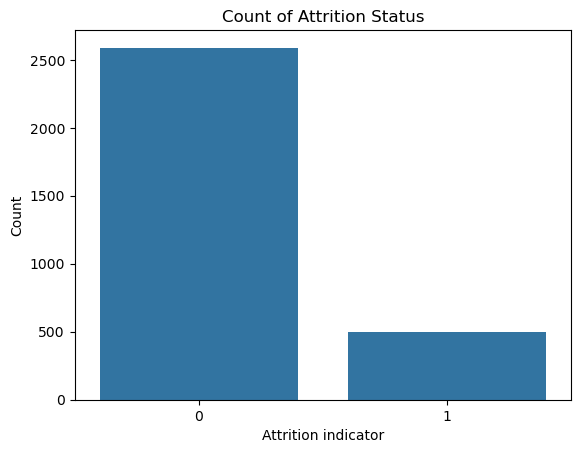

In [30]:
# Basic bar plot of SeriousDlqin2yrs
sns.countplot(x= y_train)
plt.xlabel("Attrition indicator")
plt.ylabel("Count")
plt.title("Count of Attrition Status")
plt.show()

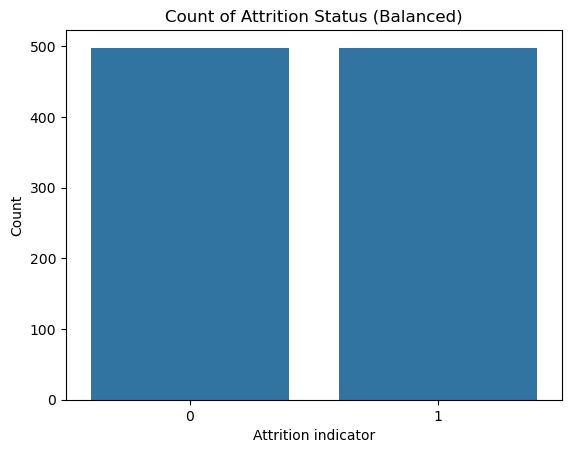


Original training set size: 3087
Balanced training set size: 996
Class distribution after balancing:
Attrition
1    498
0    498
Name: count, dtype: int64


In [32]:
# -------------------------------------------------------------------
# Step 3: Balancing Classes (Downsampling)
# -------------------------------------------------------------------

# Class imbalance: downsample the negative class (No attrition); 
# keep all positives (Yes attrition) + equal number of negatives

# Get indices for each class
pos_idx = y_train.index[y_train == 1]  # Attrition = Yes
neg_idx = y_train.index[y_train == 0]  # Attrition = No

# Randomly sample negative class to match positive class size
keep_neg = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
keep_idx = np.concatenate([pos_idx, keep_neg])

# Create balanced training sets
X_train_bal = X_train_encoded.loc[keep_idx].copy()
y_train_bal = y_train.loc[keep_idx].copy()

# Quick look after balancing
sns.countplot(x=y_train_bal)
plt.xlabel("Attrition indicator")
plt.ylabel("Count")
plt.title("Count of Attrition Status (Balanced)")
plt.show()

print(f"\nOriginal training set size: {len(y_train)}")
print(f"Balanced training set size: {len(y_train_bal)}")
print(f"Class distribution after balancing:\n{y_train_bal.value_counts()}")

In [33]:
f1_1 = sm.Logit(y_train_bal, sm.add_constant(X_train_bal['Age'])).fit()
print("\n=== f1 summary ===")
print(f1.summary())

Optimization terminated successfully.
         Current function value: 0.672215
         Iterations 4

=== f1 summary ===
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3085
Method:                           MLE   Df Model:                            1
Date:                Wed, 26 Nov 2025   Pseudo R-squ.:                 0.03869
Time:                        20:27:32   Log-Likelihood:                -1311.2
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 9.299e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4516      0.213      2.124      0.034       0.035       0.868
Age      

In [34]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on TRAINING data (not test!)
train_probs = f1_1.predict(sm.add_constant(X_train_bal['Age']))

# Calculate precision and recall
train_pred_class = (train_probs >= 0.5).astype(int)

cm_train = confusion_matrix(y_train_bal, train_pred_class)
precision_train = precision_score(y_train_bal, train_pred_class)
recall_train = recall_score(y_train_bal, train_pred_class)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train:.3f}")
print(f"Recall (train):    {recall_train:.3f}")


In-sample confusion matrix (threshold = 0.5):
          Pred 0  Pred 1
Actual 0     275     223
Actual 1     172     326

Precision (train): 0.594
Recall (train):    0.655


---

### need to fix this function

In [44]:
def log_regression_function(x_df, y_df, features):
    f1 = sm.Logit(y_df, sm.add_constant(x_df[features])).fit()
    ### now that the Logit model has been created, VIF model table
    def vif_table(model):
        X = model.model.exog
        names = model.model.exog_names
        vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        return pd.DataFrame({"variable": names, "VIF": vif_values})
    vif_df = vif_table(f1)
    ### now let us create a ROC/AUC/Precision/Recall
    train_probs = f1.predict(sm.add_constant(x_df[features]))
    train_pred_class = (train_probs >= 0.5).astype(int)

    cm_train = confusion_matrix(y_df, train_pred_class)
    precision_train = precision_score(y_df, train_pred_class)
    recall_train = recall_score(y_df, train_pred_class)
    recall_df = pd.DataFrame(cm_train, index = ['Actual 0' , 'Actual 1'] , columns=['Pred 0' , 'Pred 1'])


    # define 5-Fold Stratified CV ( preserve class proportions)
    cv = StratifiedKFold( # sets up CV object
    n_splits=5, # how many folds?
    shuffle=True, # True means stratify by the class variable
    random_state=42)

    knn_pipeline = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))])

    scores_knn = cross_val_score(
        knn_pipeline,
        x_df[features],
        y_df,
        cv=cv,
        scoring="accuracy"
        )

    return f1.summary, vif_df , recall_df , precision_train, recall_train, scores_knn


log_regression_function(X_train_bal, y_train_bal , ['Age' , 'DistanceFromHome' , 'JobLevel' , 'NumCompaniesWorked'])

Optimization terminated successfully.
         Current function value: 0.665019
         Iterations 5


(<bound method BinaryResults.summary of <statsmodels.discrete.discrete_model.LogitResults object at 0x00000221019048D0>>,
              variable        VIF
 0               const  19.387201
 1                 Age   1.110994
 2    DistanceFromHome   1.010757
 3            JobLevel   1.008108
 4  NumCompaniesWorked   1.108393,
           Pred 0  Pred 1
 Actual 0     270     228
 Actual 1     176     322,
 0.5854545454545454,
 0.6465863453815262,
 array([0.585     , 0.57788945, 0.57286432, 0.58291457, 0.59798995]))

---

In [45]:
model_1_features = ['Age']
knn_pipeline = Pipeline(steps=[
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_knn = cross_val_score(
        knn_pipeline,
        X_train_encoded[model_1_features],
        y_train,
        cv=cv,
        scoring="accuracy"
    )

scores_knn

array([0.8381877 , 0.8381877 , 0.83954619, 0.83954619, 0.83792545])

### goal create a pipeline function 

In [12]:
y_train

2685    0
3631    0
1365    0
3623    0
4390    0
       ..
3369    0
3858    0
743     0
808     0
1125    0
Name: Attrition, Length: 3087, dtype: int64

In [9]:
def model_pipeline(features):    
    # Create the pipeline
    knn_pipeline = Pipeline(steps=[
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ])
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate cross-validation scores
    scores_knn = cross_val_score(
        knn_pipeline,
        X_train_encoded[features],
        y_train,
        cv=cv,
        scoring="accuracy"
    )
    
    print(f"KNN imputation + pipeline CV accuracy: {scores_knn.mean():.4f}")
    
    # Fit on training set
    knn_pipeline.fit(X_train_encoded[features], y_train)
    
    # Predict and evaluate on test set
    y_pred = knn_pipeline.predict(X_test_encoded[features])
    
    test_auc = roc_auc_score(y_test, y_pred)
    print(f"Test AUC with KNN imputation: {test_auc:.4f}")
    
    return scores_knn.mean(), test_auc

In [10]:
model_pipeline(['Age', 'Gender_Male'])

KNN imputation + pipeline CV accuracy: 0.8387
Test AUC with KNN imputation: 0.5000


(np.float64(0.8386786465463434), np.float64(0.5))

In [11]:
model_pipeline(['Age', 'Gender_Male' , 'JobSatisfaction'])

KNN imputation + pipeline CV accuracy: 0.8387
Test AUC with KNN imputation: 0.5000


(np.float64(0.8386786465463434), np.float64(0.5))